# Fake News Detection Exploratory Data Analysis

## 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import heapq

#Visualization library
import matplotlib.pyplot as plt

#Text processing libraries
import nltk 
from nltk.corpus import stopwords
import texthero as hero
import re
import string

#DEPENDACIES
#nltk.download()
#pip install texthero==1.0.9
#pip install gensim==3.8.3

## 2. Loading The Data

In [2]:
train_data=pd.read_csv('train.csv') # The CSV files are placed in the same folder as the .ipynb file
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## 3. Data-Preprocessing

Data cleaning is done in three stages namely:

1. Drop features that are not needed
2. Removing the Null values
3. Text Processing

### 3.1 Drop features that are not needed

In [3]:
train_data = train_data.drop(columns = ["id","author"])

### 3.2 Removing the Null Values

In [4]:
train_data.isnull().sum() #Checking the data set for null values
train_data.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [5]:
train_data.dropna(inplace= True)

In [6]:
train_data.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [7]:
train_data.head()

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1


### 3.3 Text Processing

In [8]:
#A function to remove unneccassary characters and convert text to lower case
def word_edit(text):
    text= text.lower()
    text = re.sub("\[.*?\]","",text)
    text = re.sub("\\W"," ",text)
    text = re.sub("https?://\S+www\.\S+","",text)
    text = re.sub("<.*?>+","",text)
    text = re.sub("[%s]" % re.escape(string.punctuation),"",text)
    text = re.sub("\n","",text)
    text = re.sub("\w*\d\w*","",text)       
    return text

In [9]:
train_data["title"] = train_data["title"].apply(word_edit) #Remove characters from data and convert to lowercase
train_data["text"] = train_data["text"].apply(word_edit)

In [10]:
train_data.head()

,title,text,label
0,house dem aide we didn t even see comey s let...,house dem aide we didn t even see comey s let...,1
1,flynn hillary clinton big woman on campus ...,ever get the feeling your life circles the rou...,0
2,why the truth might get you fired,why the truth might get you fired october ...,1
3,civilians killed in single us airstrike have ...,videos civilians killed in single us airstrik...,1
4,iranian woman jailed for fictional unpublished...,print an iranian woman has been sentenced to ...,1


In [11]:
stopwords_dict=dict.fromkeys(stopwords.words('english'))
#stopwords.words from the nltk library returns a list constaining stopwords. We change the list to a dictionary reducing
# access time when finding the word therefore reducing computation time.

In [12]:
# Function to remove stop words
def removestopwords(words):
    many_words=words.split()
    word=""
    for s in many_words:
        if s not in stopwords_dict:
            word+=s+" "
    return word

In [13]:
train_data["title"] = train_data["title"].apply(removestopwords) #removing stop words from the text
train_data["text"] = train_data["text"].apply(removestopwords)

In [14]:
stored_data = train_data[['text','title','label']].copy() #Copying data to another dataframe

In [15]:
stored_data.head()

,text,title,label
0,house dem aide even see comey letter jason cha...,house dem aide even see comey letter jason cha...,1
1,ever get feeling life circles roundabout rathe...,flynn hillary clinton big woman campus breitbart,0
2,truth might get fired october tension intellig...,truth might get fired,1
3,videos civilians killed single us airstrike id...,civilians killed single us airstrike identified,1
4,print iranian woman sentenced six years prison...,iranian woman jailed fictional unpublished sto...,1


In [16]:
stored_data.isnull().sum() #checking if there is null values after removing stop words

text     0
title    0
label    0
dtype: int64

In [17]:
stored_data.dropna(inplace= True)#removing null values

In [18]:
stored_data.isnull().sum()# Checking if all null values have been removed

text     0
title    0
label    0
dtype: int64

## 4. Exploratory Data Analysis

### 4.1 Fake vs True news data set samples

Firstly, we see if there is an equal number of samples of true and false news

In [19]:
stored_data['label'].value_counts()

0    10387
1     9816
Name: label, dtype: int64

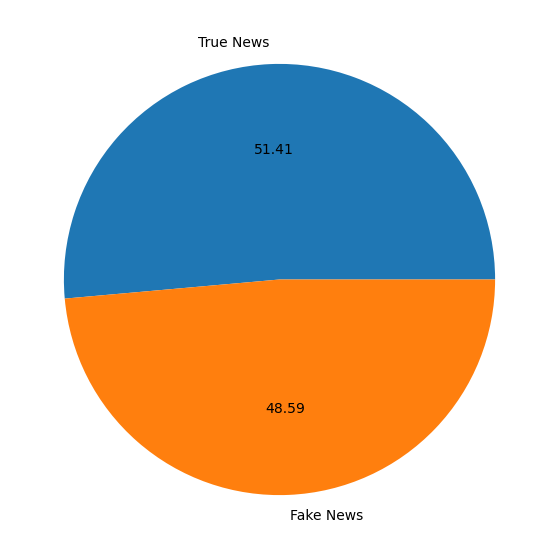

In [20]:
fig = plt.figure(figsize =(10, 7))
mylabels=["True News","Fake News"]
plt.pie(stored_data['label'].value_counts(),labels=mylabels,autopct='%.2f')
plt.show()

The above pie chart shows that there is a slightly larger sample size of true news compared to fake news therefore the model trained will be able to predict true news slightly better than fake news.

### 4.2 N-Gram analysis

We perfrom n-gram analysis by counting the consecutive number of n words appearing in the text.

In [21]:
# A function to count a single word frequency
def countwords(words,Dic):
    many_words=words.split()
    for s in many_words:
        if s not in Dic:
            Dic[s]=1
        else:
            Dic[s]=Dic[s]+1
    return Dic

We check the word frequency appearing in the text and title below using the countwords function.

In [22]:
Dict1={}
stored_data["title"].apply(countwords,args=(Dict1,))
list1=heapq.nlargest(20,Dict1,key=Dict1.get)
for i,item in enumerate(list1):
    print(list1[i]," ",Dict1[list1[i]])

new   7118
york   6372
times   6353
trump   3722
breitbart   2402
hillary   1263
clinton   1216
donald   886
u   639
election   596
obama   580
news   552
russia   530
us   473
war   435
america   423
says   415
president   390
world   383
fbi   366


In [23]:
Dict2={}
stored_data["text"].apply(countwords,args=(Dict2,))
list2=heapq.nlargest(20,Dict2,key=Dict2.get)
for x,item2 in enumerate(list2):
    print(list2[x]," ",Dict2[list2[x]])

said   79221
mr   66206
trump   55177
one   38169
would   36818
people   35980
new   29213
clinton   27186
like   26037
also   25068
president   24797
time   20869
state   20023
us   19870
could   19153
many   19007
even   18699
years   17683
states   17378
two   17265


The above shows the most frequent words appearing in the dataset which will be used to train the model. We further split the data into true and fake news to visualise the top string of words/n-grams appearing in the given data set.

In [24]:
#Making an empty dataframe to access the label column of the data.
d = {'col1': [0,1]}
df = pd.DataFrame(data=d)

In [25]:
#Splitting the data into true and false news
temp=stored_data.groupby('label')
fake=temp.get_group(df.col1[0])
true=temp.get_group(df.col1[1])
true.head()

,text,title,label
0,house dem aide even see comey letter jason cha...,house dem aide even see comey letter jason cha...,1
2,truth might get fired october tension intellig...,truth might get fired,1
3,videos civilians killed single us airstrike id...,civilians killed single us airstrike identified,1
4,print iranian woman sentenced six years prison...,iranian woman jailed fictional unpublished sto...,1
6,ever wonder britain iconic pop pianist gets lo...,life life luxury elton john favorite shark pic...,1


There are many bar graphs that can be drawn from the data set. Majority of text from the data set will come from the 'text' column thus we will further analyse the 'text' feature and not 'title'.

In [26]:
#Counting the top words in fake news
Dict3={}
fake["text"].apply(countwords,args=(Dict3,))
list3=heapq.nlargest(20,Dict3,key=Dict3.get)
list6=[]
for i,item in enumerate(list3):
    list6.append(Dict3[list3[i]])

In [27]:
#Counting the top words in true news
Dict4={}
true["text"].apply(countwords,args=(Dict4,))
list4=heapq.nlargest(20,Dict4,key=Dict4.get)
list5=[]
for i,item in enumerate(list4):
    list5.append(Dict4[list4[i]])

#### 4.2.1 Unigram (One word)

A plot of the most frequent occuring words in true news and false news is plotted on a bar graph respectively.

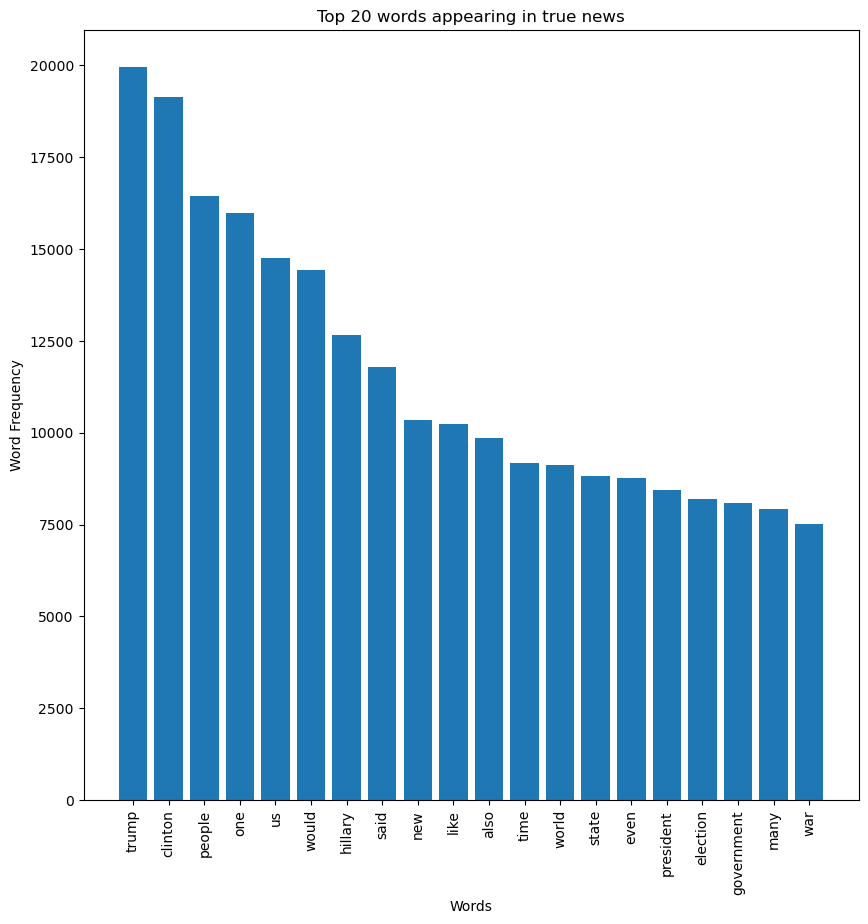

In [28]:
#Plotting bar graph for unigrams appearing in true news
fig = plt.figure(figsize = (10, 10))
plt.bar(list4, list5)
plt.xlabel("Words")
plt.ylabel("Word Frequency")
plt.title("Top 20 words appearing in true news")
plt.xticks(rotation=90)
plt.show()

The above bar graph shows that the most true news contains of US politics.

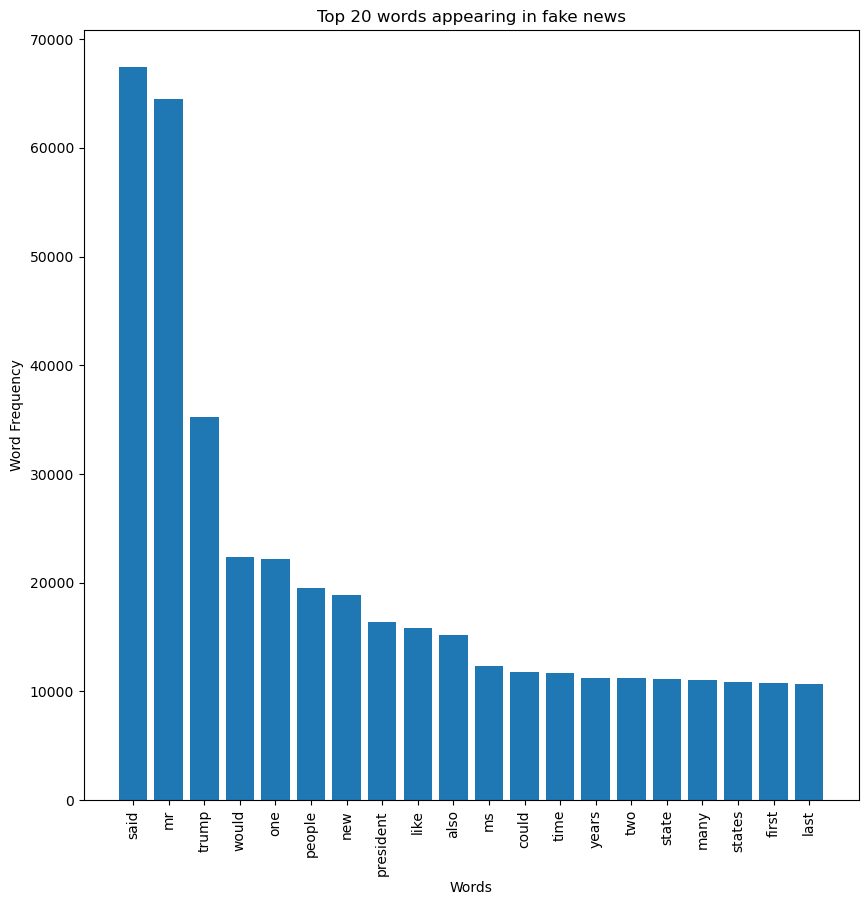

In [29]:
#Plotting bar graph for unigrams appearing in fake news
fig2 = plt.figure(figsize = (10, 10))
plt.bar(list3, list6)
plt.xlabel("Words")
plt.ylabel("Word Frequency")
plt.title("Top 20 words appearing in fake news")
plt.xticks(rotation=90)
plt.show()

The above bar graph shows that like true news, US plotics is also the most reported news of this data set. It is interesting to note that the word 'said' appears most frequently in false news whereas in true news it does not appear in the top 20 words. This is most likely due to false news misquoting people or taking what the speaker said out of context. 

#### 4.2.2 Bigram (Two words)

A bar graph of the most frequent bigrams is to be plotted.

In [30]:
#We further extend the function to count single words in order to do n-gram analysis. This function takes in
#the sentence, an empty dictionary to store results and n the number of consecutive words to look for.
def gram(words,Dic,n):
    many_words=words.split()
    temp=zip(*[many_words[i:] for i in range(0,n)])
    ans=[' '.join(ngram) for ngram in temp]
    for s in ans:
        if s not in Dic:
            Dic[s]=1
        else:
            Dic[s]=Dic[s]+1
    return Dic

In [31]:
#Counting the top bigrams in true news
Dict5={}
true["text"].apply(gram,args=(Dict5,2))
list7=heapq.nlargest(20,Dict5,key=Dict5.get)
list8=[]
for i,item in enumerate(list7):
    list8.append(Dict5[list7[i]])

In [32]:
#Counting the top bigrams in fake news
Dict6={}
fake["text"].apply(gram,args=(Dict6,2))
list9=heapq.nlargest(20,Dict6,key=Dict6.get)
list10=[]
for i,item in enumerate(list9):
    list10.append(Dict6[list9[i]])

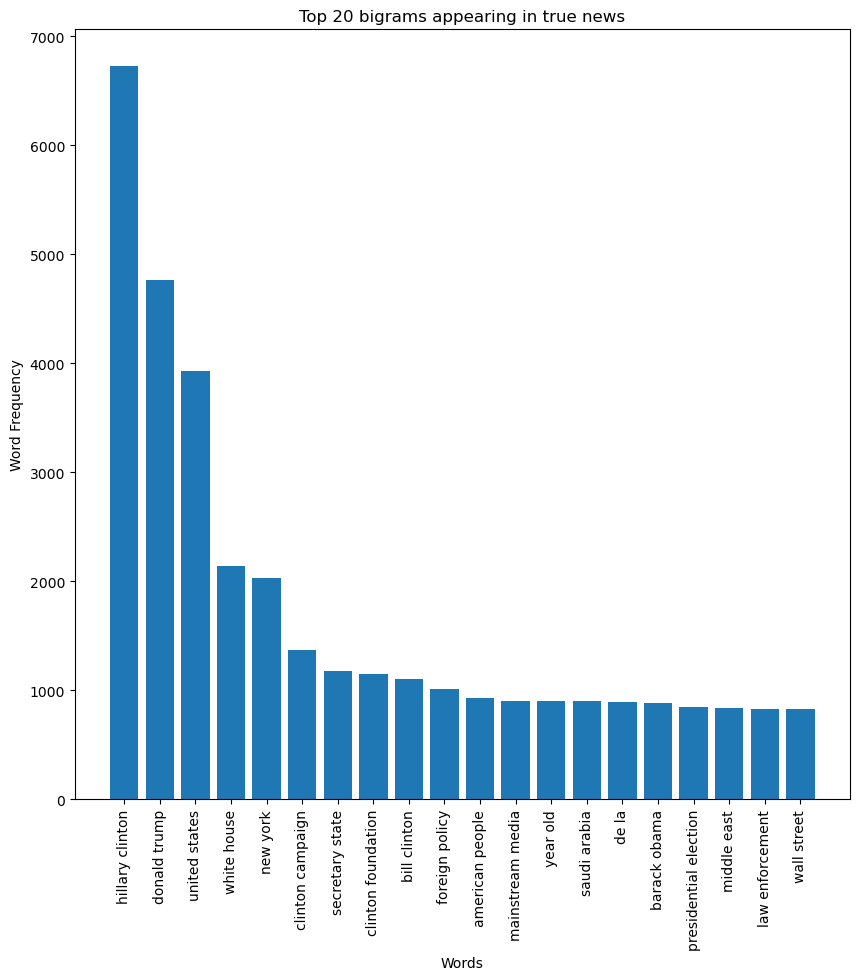

In [33]:
#Plotting bar graph for bigrams appearing in true news
fig3 = plt.figure(figsize = (10, 10))
plt.bar(list7, list8)
plt.xlabel("Words")
plt.ylabel("Word Frequency")
plt.title("Top 20 bigrams appearing in true news")
plt.xticks(rotation=90)
plt.show()

The above bar graph shows once again that most true news in this dataset consists of US politics

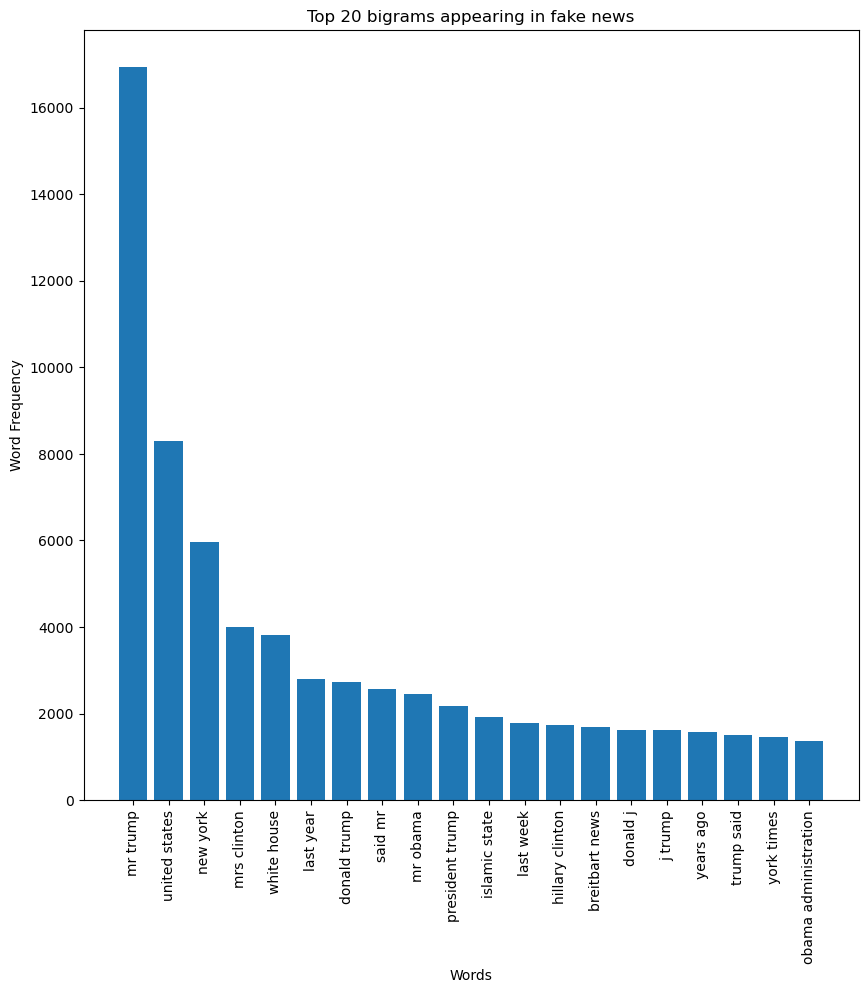

In [34]:
#Plotting bar graph for bigrams appearing in fake news
fig4 = plt.figure(figsize = (10, 10))
plt.bar(list9, list10)
plt.xlabel("Words")
plt.ylabel("Word Frequency")
plt.title("Top 20 bigrams appearing in fake news")
plt.xticks(rotation=90)
plt.show()

The above bar graph shows that most fake news reported is about US politics, in specific most fake news contains US presidents.

#### 4.2.3 Trigram (Three words)

In [35]:
#Counting the top bigrams in true news
Dict7={}
true["text"].apply(gram,args=(Dict7,3))
list11=heapq.nlargest(20,Dict7,key=Dict7.get)
list12=[]
for i,item in enumerate(list11):
    list12.append(Dict7[list11[i]])

In [36]:
#Counting the top trigrams in fake news
Dict8={}
fake["text"].apply(gram,args=(Dict8,3))
list13=heapq.nlargest(20,Dict8,key=Dict8.get)
list14=[]
for i,item in enumerate(list13):
    list14.append(Dict8[list13[i]])

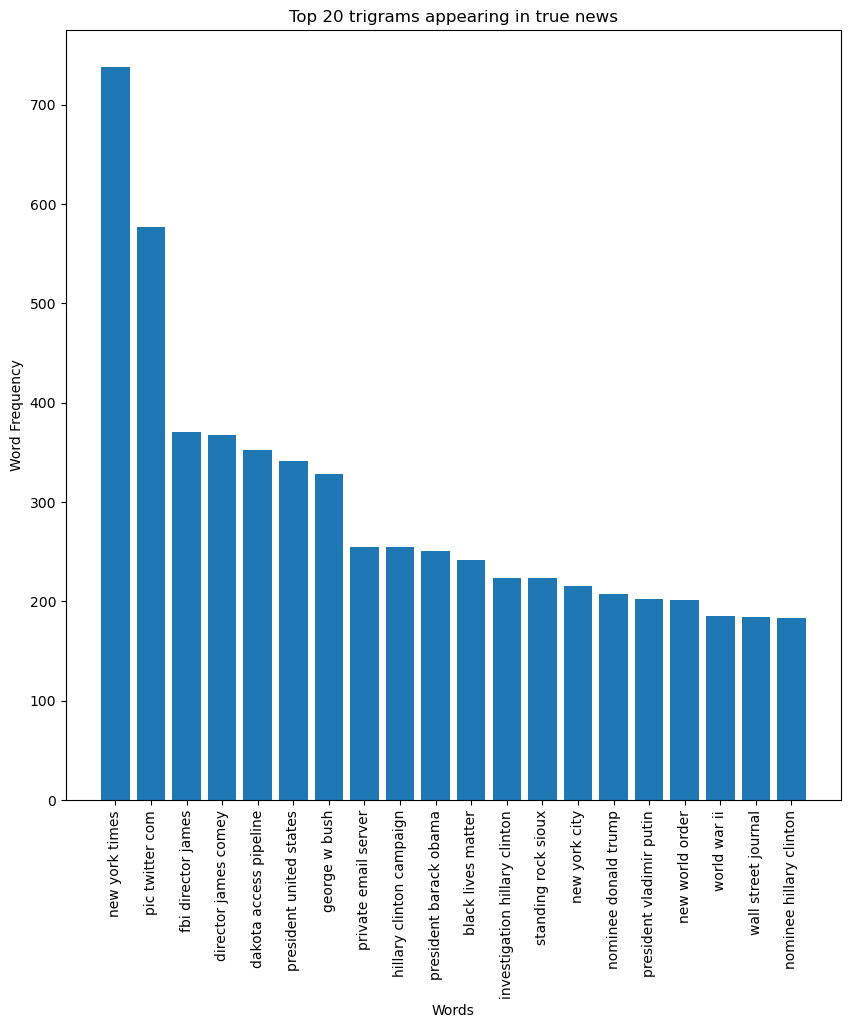

In [37]:
#Plotting bar graph for trigrams appearing in true news
fig5 = plt.figure(figsize = (10, 10))
plt.bar(list11, list12)
plt.xlabel("Words")
plt.ylabel("Word Frequency")
plt.title("Top 20 trigrams appearing in true news")
plt.xticks(rotation=90)
plt.show()

The above bar graph depicts which US politics topics specifically appears in true news

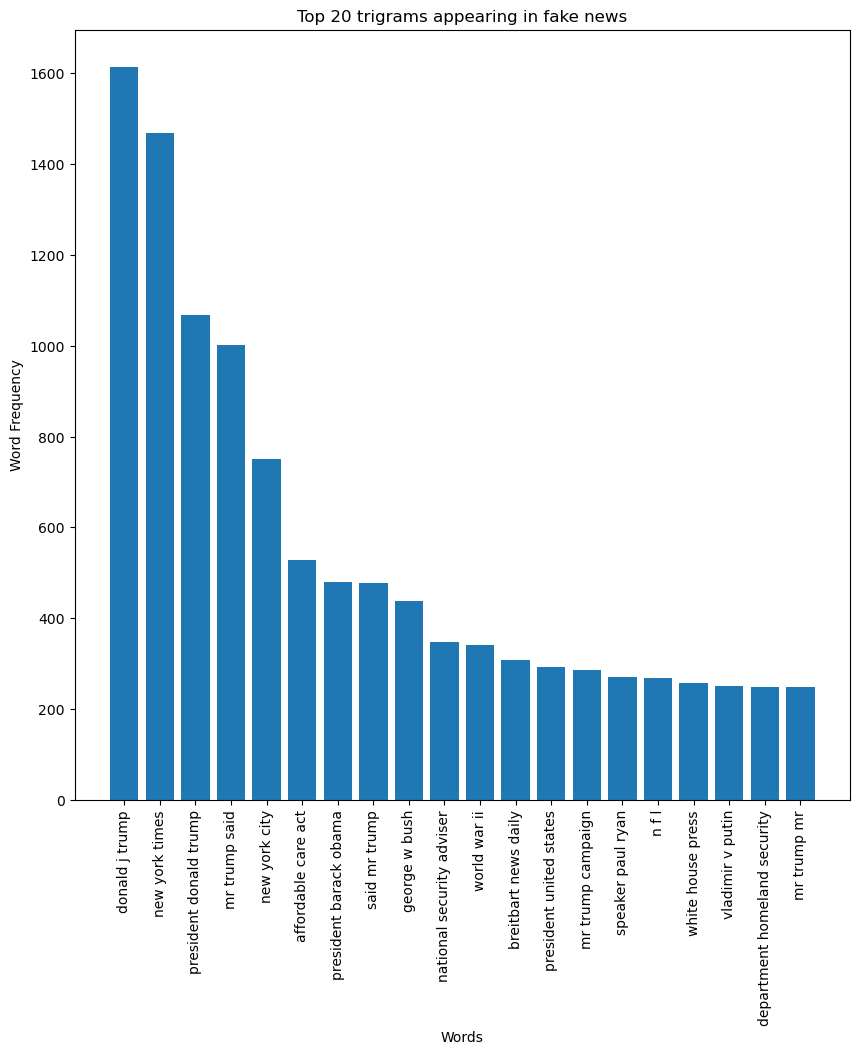

In [38]:
#Plotting bar graph for trigrams appearing in fake news
fig5 = plt.figure(figsize = (10, 10))
plt.bar(list13, list14)
plt.xlabel("Words")
plt.ylabel("Word Frequency")
plt.title("Top 20 trigrams appearing in fake news")
plt.xticks(rotation=90)
plt.show()

The above bar graph extends upon which topics in US politics contains false news, which still mostly consists of US presidents.

### 4.3 Wordcloud

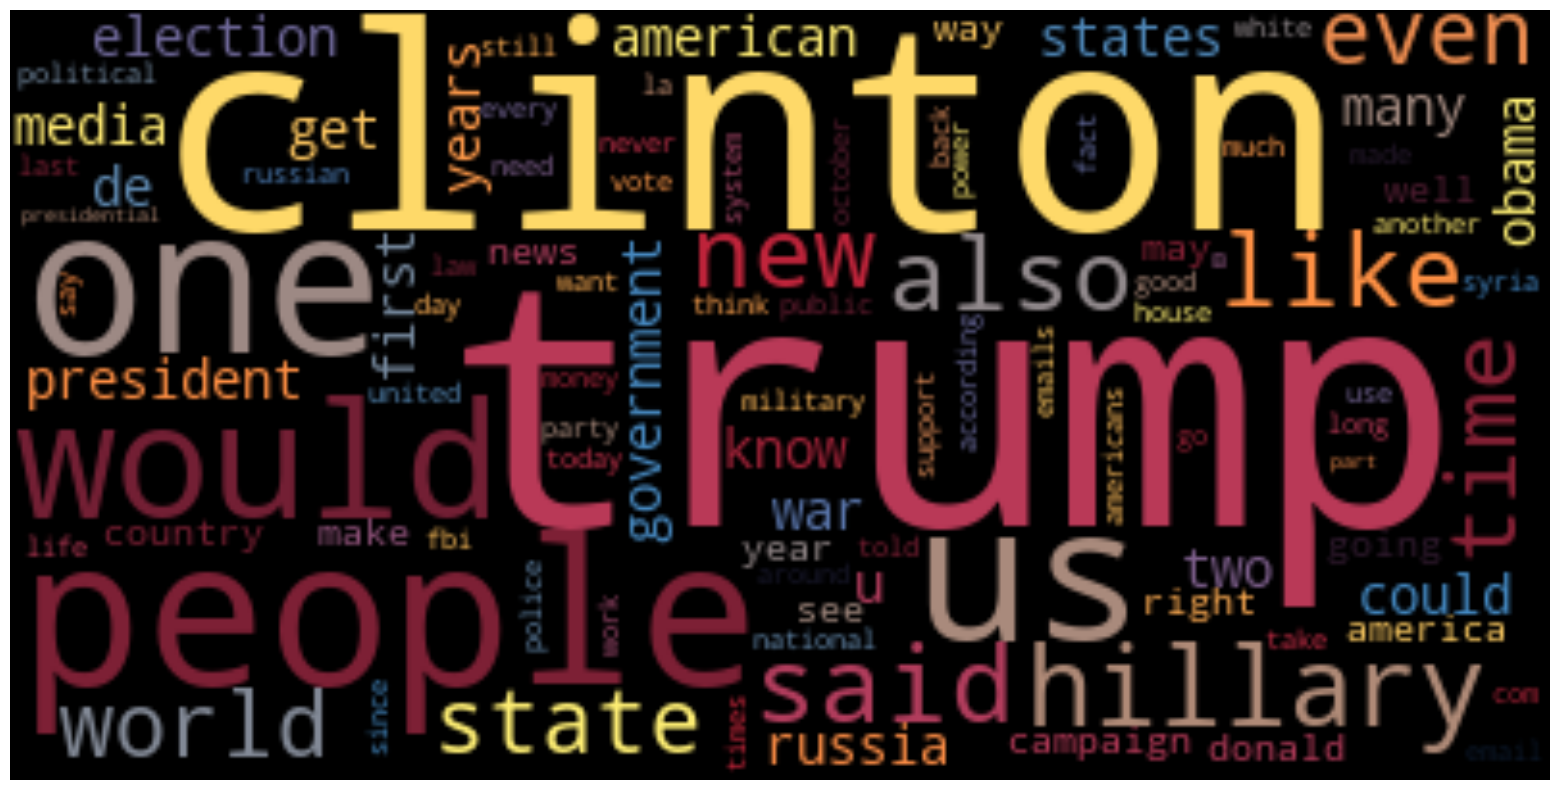

In [39]:
hero.wordcloud(true.text,max_words=100,background_color="BLACK",)

Plot of a word cloud of top words appearing in true news.

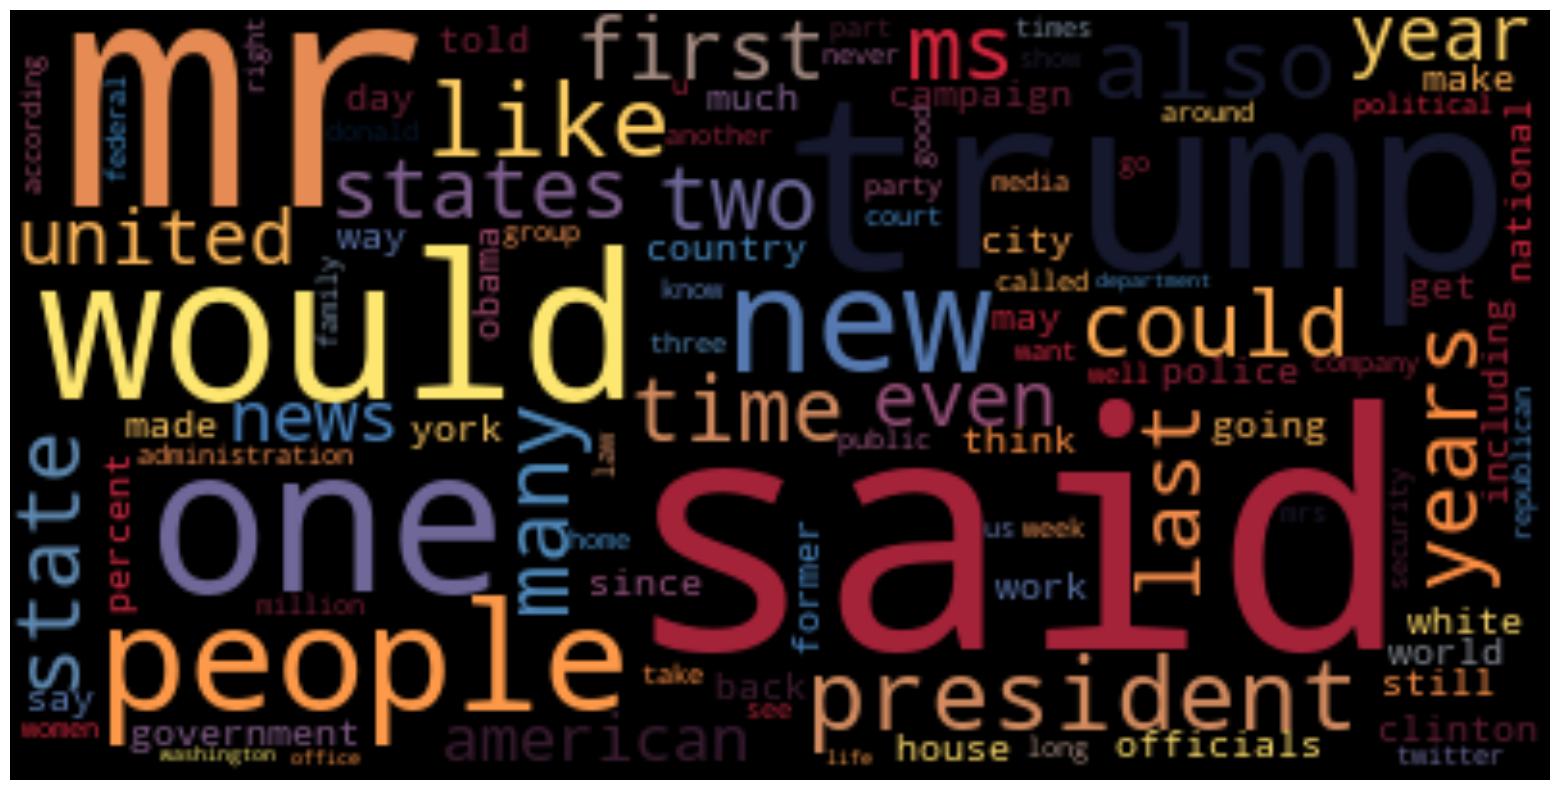

In [40]:
hero.wordcloud(fake.text,max_words=100,background_color="BLACK",height = 200,width = 400)

Plot of a word cloud of top words appearing in fake news.